<a href="https://colab.research.google.com/github/AlexGitta/NeuralNets/blob/main/LipReading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lip Reading in TensorFlow (Colab)

An attempt at using TensorFlow to analyse pixels in video files (without sound) of someone talking and produce an estimation of their speech.

I decided to use the GRID dataset, which has a good variety of speakers, although the sentence format is quite formulaic. Though this may result in a degree of overfitting, human speech is a very wide dataset and focusing on just one speaker and sentence format enabled me to create a more effective model.

The dataset can be downloaded here (speaker 20) -

https://spandh.dcs.shef.ac.uk/gridcorpus/

And I based my Neural Network on the one described in LipNet, which can be found here -

https://arxiv.org/pdf/1611.01599



In [ ]:
!pip install -U tensorflow==2.10.1 opencv-python==4.6.0.66  matplotlib

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from typing import List
from typing import Tuple

from keras.models import Sequential
from keras.initializers import Orthogonal
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully")
else:
    print("No GPU found, using CPU")

No GPU found, using CPU


I would really not recommend doing this via CPU, it is essentially impossible due to the amount of parameters. Using my laptop RTX4060 I got about 3 mins / epoch, using colabs online GPU it was longer but manageable.

# Data Loading and Preprocessing

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'1.Artificial-Intelligence.introduction (1).ipynb'   BVHFILES222        Male2_bvh	  s20.tar
 Anims_Only_FBX_V1				     carryover	        s20
 Anims_Only_FBX_V1.zip				    'Colab Notebooks'  's20 (1)'
 BVHFILES					     FBXFILES	        s20.mpg_vcd.zip


Unzip video and alignment files into dataset folder in colab

In [ ]:
import gdown
gdown.extractall("/content/drive/My Drive/s20.mpg_vcd.zip", "/content/dataset")

['/content/dataset/s20/',
 '/content/dataset/s20/sris2a.mpg',
 '/content/dataset/s20/srbm4s.mpg',
 '/content/dataset/s20/swbt5p.mpg',
 '/content/dataset/s20/sbae9n.mpg',
 '/content/dataset/s20/bgil2s.mpg',
 '/content/dataset/s20/lgwlza.mpg',
 '/content/dataset/s20/pbat6a.mpg',
 '/content/dataset/s20/sbbz8a.mpg',
 '/content/dataset/s20/swbm9n.mpg',
 '/content/dataset/s20/prwo6a.mpg',
 '/content/dataset/s20/lwbkza.mpg',
 '/content/dataset/s20/lbwc7p.mpg',
 '/content/dataset/s20/pgbv6s.mpg',
 '/content/dataset/s20/sgwn9n.mpg',
 '/content/dataset/s20/sbws6s.mpg',
 '/content/dataset/s20/lbwv9p.mpg',
 '/content/dataset/s20/srwt3p.mpg',
 '/content/dataset/s20/swiz9n.mpg',
 '/content/dataset/s20/lbbp1p.mpg',
 '/content/dataset/s20/bgbs5p.mpg',
 '/content/dataset/s20/lwip5p.mpg',
 '/content/dataset/s20/brwr7p.mpg',
 '/content/dataset/s20/bbby1p.mpg',
 '/content/dataset/s20/bgwtza.mpg',
 '/content/dataset/s20/brbr3p.mpg',
 '/content/dataset/s20/praa7n.mpg',
 '/content/dataset/s20/lwax1n.mpg',
 '

In [ ]:
gdown.extractall("/content/drive/My Drive/s20.tar", "/content/dataset/alignments")

['/content/dataset/alignments/align',
 '/content/dataset/alignments/align/bbad3n.align',
 '/content/dataset/alignments/align/bbad4s.align',
 '/content/dataset/alignments/align/bbad5p.align',
 '/content/dataset/alignments/align/bbad6a.align',
 '/content/dataset/alignments/align/bbaj7n.align',
 '/content/dataset/alignments/align/bbaj8s.align',
 '/content/dataset/alignments/align/bbaj9p.align',
 '/content/dataset/alignments/align/bbakza.align',
 '/content/dataset/alignments/align/bbaq1n.align',
 '/content/dataset/alignments/align/bbaq2s.align',
 '/content/dataset/alignments/align/bbaq3p.align',
 '/content/dataset/alignments/align/bbaq4a.align',
 '/content/dataset/alignments/align/bbax5n.align',
 '/content/dataset/alignments/align/bbax6s.align',
 '/content/dataset/alignments/align/bbax7p.align',
 '/content/dataset/alignments/align/bbax8a.align',
 '/content/dataset/alignments/align/bbbd7n.align',
 '/content/dataset/alignments/align/bbbd8s.align',
 '/content/dataset/alignments/align/bbbd9p.a

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []   # create frames array
    for _ in range(75):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) # grayscale
        frames.append(frame[200:246,110:250,:]) # take only mouth portion (see below for matplotlib visualisation of frames)
                                               # i just used trial + error to find the right cutout
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std # calculate mean and std deviation and scale image

Conversion functions taken from
https://keras.io/examples/audio/ctc_asr/

In [ ]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':  # all lines that are not "silence"
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
     # add to tokens array as numbers (using conversion function)

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('dataset','s20',f'{file_name}.mpg') # using .join to set paths for the video and alignments
    alignment_path = os.path.join('dataset','alignments','align',f'{file_name}.align')
    frames = load_video(video_path) # using load functions to add frames and alignments to arrays
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [ ]:
testing = './dataset/s20/bbwk7p.mpg'

In [ ]:
load_data(tf.convert_to_tensor(testing)) # This returns the frames and alignments, ready for the NN
                                      # Note the shape

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[0.18361333],
          [6.5838494 ],
          [6.3477755 ],
          ...,
          [5.377248  ],
          [5.3247867 ],
          [5.534631  ]],
 
         [[0.15738286],
          [6.5838494 ],
          [6.3477755 ],
          ...,
          [5.377248  ],
          [5.3247867 ],
          [5.534631  ]],
 
         [[0.15738286],
          [6.5838494 ],
          [6.3477755 ],
          ...,
          [5.377248  ],
          [5.3247867 ],
          [5.534631  ]],
 
         ...,
 
         [[6.4789276 ],
          [6.4789276 ],
          [6.5313888 ],
          ...,
          [5.403478  ],
          [5.377248  ],
          [5.560861  ]],
 
         [[6.557619  ],
          [6.5313888 ],
          [6.5313888 ],
          ...,
          [5.403478  ],
          [5.377248  ],
          [5.560861  ]],
 
         [[6.557619  ],
          [6.557619  ],
          [6.4789276 ],
          ...,
          [5.403478  ],
    

In [ ]:
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
      return result #format data for tensorflow

### Using MatPlotLib to visualise frames

As you can see, MPL can be used to show what the NN sees. I used this (and trial + error on as many clips as I had patience for ) to center the mouth in the image, as this is the only part of the face we are interested in.

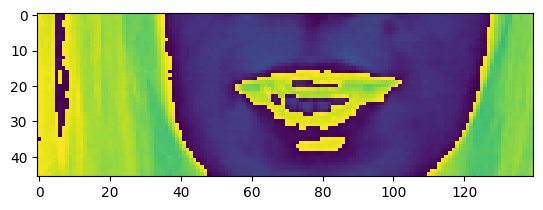

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(testing))
plt.imshow(frames[34])

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with k seven please'>

# Data Pipeline

In [ ]:
data = tf.data.Dataset.list_files('./dataset/s20/*.mpg')  # all mpg files from dataset
data = data.shuffle(1000, reshuffle_each_iteration=False)  # shuffle them
data = data.map(mappable_function)   # use function to map them to TF format

 # setting data batches, 2 vids of 50 frames, 40 tokens
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

 # split into training and test data
train = data.take(800)
test = data.skip(800)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
test = data.as_numpy_iterator()

In [ ]:
val = test.next(); val[0]

array([[[[[0.43196374],
          [0.27950594],
          [6.4540462 ],
          ...,
          [5.361432  ],
          [5.310613  ],
          [5.4884806 ]],

         [[0.43196374],
          [0.27950594],
          [6.4540462 ],
          ...,
          [5.361432  ],
          [5.310613  ],
          [5.4884806 ]],

         [[0.43196374],
          [0.27950594],
          [6.4540462 ],
          ...,
          [5.310613  ],
          [5.310613  ],
          [5.463071  ]],

         ...,

         [[6.479456  ],
          [6.326998  ],
          [6.123721  ],
          ...,
          [5.310613  ],
          [5.361432  ],
          [5.437661  ]],

         [[6.4286366 ],
          [6.352408  ],
          [6.123721  ],
          ...,
          [5.3360224 ],
          [5.361432  ],
          [5.437661  ]],

         [[6.4286366 ],
          [6.352408  ],
          [6.123721  ],
          ...,
          [5.3360224 ],
          [5.361432  ],
          [5.437661  ]]],


        [[[0.4827

Visualisation of video

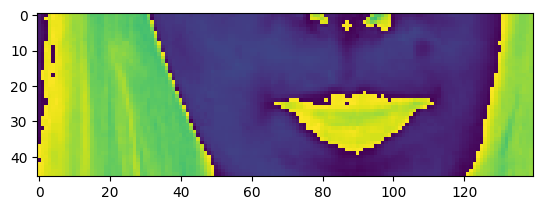

In [ ]:
plt.imshow(val[0][0][6])  # 0 for frames not alignments, 0 for video one of two, 6 for frame 6

Transcript of video

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green in m eight soon'>

# Deep Learning

##Building the NN

In [ ]:
model = Sequential()

# First Conv3D Layer
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After First Conv3D: {model.output_shape}")

# Second Conv3D Layer
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Second Conv3D: {model.output_shape}")

# Third Conv3D Layer
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Third Conv3D: {model.output_shape}")

# TimeDistributed Flatten Layer
model.add(TimeDistributed(Flatten()))
print(f"After TimeDistributed Flatten: {model.output_shape}")


initializer = keras.initializers.Orthogonal()
# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer=initializer, return_sequences=True)))
print(f"After First Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer=initializer, return_sequences=True)))
print(f"After Second Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Dense Layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
print(f"After Dense Layer: {model.output_shape}")


After First Conv3D: (None, 75, 23, 70, 128)
After Second Conv3D: (None, 75, 11, 35, 256)
After Third Conv3D: (None, 75, 5, 17, 75)
After TimeDistributed Flatten: (None, 75, 6375)
After First Bidirectional LSTM: (None, 75, 256)
After Second Bidirectional LSTM: (None, 75, 256)
After Dense Layer: (None, 75, 41)


In [ ]:

model = Sequential()

# First Conv3D Layer
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After First Conv3D: {model.output_shape}")

# Second Conv3D Layer
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Second Conv3D: {model.output_shape}")

# Third Conv3D Layer
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))
print(f"After Third Conv3D: {model.output_shape}")

# TimeDistributed Flatten Layer
model.add(TimeDistributed(Flatten()))
print(f"After TimeDistributed Flatten: {model.output_shape}")

# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)))
print(f"After First Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(128, kernel_initializer= Orthogonal(), return_sequences=True)))
print(f"After Second Bidirectional LSTM: {model.output_shape}")
model.add(Dropout(.5))

# Dense Layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))
print(f"After Dense Layer: {model.output_shape}")


After First Conv3D: (None, 75, 23, 70, 128)
After Second Conv3D: (None, 75, 11, 35, 256)
After Third Conv3D: (None, 75, 5, 17, 75)
After TimeDistributed Flatten: (None, 75, 6375)
After First Bidirectional LSTM: (None, 75, 256)
After Second Bidirectional LSTM: (None, 75, 256)
After Dense Layer: (None, 75, 41)


In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

###Untrained prediction

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 14s 14s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllljjj'>

As you can see, not a very succesful prediction

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

###Learning Rate and Loss Function

In [ ]:
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_path = os.path.join('/content/drive/My Drive/Colab Notebooks/savedmodels','lipcheckpoint.weights.h5')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', save_best_only=True, save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(train)

In [39]:
model.fit(train, validation_data=test, epochs = 10, callbacks=[schedule_callback, example_callback])

Epoch 1/10
  1/500 [..............................] - ETA: 12:02:24 - loss: 241.3404

KeyboardInterrupt: 